In [1]:
#accessing netcdf files from Hector's folders
import os, glob, sys
sys.path.append("//nobackup//amondal//Python//Hector_Python_Scripts")
sys.path.append("//nobackup/amondal//Python//mit_geos_analysis")
#from mds_store import openmdsdataset
#playing with netcdf - xarray
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
# How about visualization?
%matplotlib inline
import netCDF4
from netCDF4 import Dataset
#from xmitgcm import open_mdsdataset
from GetNCDataSet import getMITNCDataSet
from MITllc2160Depth import *
sys.path.append("//nobackup/amondal//Python//xmitgcm//xmitgcm")
from xmitgcm.mds_store import open_mdsdataset
import xrft


from dask.distributed import Client
client = Client(memory_limit='100GB',n_workers = 40, threads_per_worker=1)

/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39908 instead
  warnings.warn(


In [2]:
from spectral_analysis_code import *

In [3]:
W15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'W', 15,15)
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'Theta', 15,15)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [4]:
W15c = W15.W.compute()
T15c = T15.Theta.compute()

_________________________________________________________________________________________________________________

In [9]:
W15c = W15.W.compute()[0:int(W15c.time.size / 2)]
T15c = T15.Theta.compute()[0:int(W15c.time.size / 2)]

2208

In [8]:
W15_reg = regularizeCoordinates(W15c,'linear',timeunits = 'hours')
T15_reg = regularizeCoordinates(T15c,'linear',timeunits = 'hours')

In [11]:
W15_t = xrft.detrend(W15_reg, dim = 'time', detrend_type = 'linear')
W15_txy = xrft.detrend(W15_t, dim = ['xdim','ydim'], detrend_type = 'linear')
T15_t = xrft.detrend(T15_reg, dim = 'time', detrend_type = 'linear')
T15_txy = xrft.detrend(T15_t, dim = ['xdim','ydim'], detrend_type = 'linear')

In [12]:
W15_np = W15_txy.values
W15_np_swap = np.swapaxes(np.swapaxes(W15_np, 0, 1), 1,2)
T15_np = T15_txy.values
T15_np_swap = np.swapaxes(np.swapaxes(T15_np, 0, 1), 1, 2)

In [14]:
dx = W15_txy.xdim.diff('xdim').mean().values
dy = W15_txy.ydim.diff('ydim').mean().values
dt = W15_txy.time.diff('time').mean().values

In [15]:
dt

array(1.)

In [16]:
u = W15_np_swap
v = T15_np_swap

In [17]:
import co_spec

In [18]:
# Preambule
iy,ix,it = u.shape
#print(it,iy,ix)
iaux = (30*24)#(60*24*7)/10 #(7*24)
nt = np.around(it/(iaux),decimals=1)
print(nt)

# Calclate the 3D spectrum
for i in range(int(nt)):
      uaux = u[:,:,i*iaux:i*iaux+iaux]
      vaux = v[:,:,i*iaux:i*iaux+iaux]
      if i == 0:
         Eu,k,l,om, df1, df2, df3 = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
      else:
         Eua,_,_,_,_,_,_ = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
         Eu = Eu + Eua
Eu = Eu/nt
#USE SAME RESOLUTION IN THE DX AND DY!!!

6.1
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993


In [19]:
def calc_ispec(k,l,E):
    """ calculates isotropic spectrum from 2D spectrum """

    dk,dl = k[1,]-k[0],l[1]-l[0]
    l,k = np.meshgrid(l,k)
    wv = np.sqrt(k**2 + l**2)

    if k.max()>l.max():
        kmax = l.max()
    else:
        kmax = k.max()

    # create radial wavenumber
    dkr = np.sqrt(dk**2 + dl**2)
    kr =  np.arange(dkr/2.,kmax+dkr,dkr)
    ispec = np.zeros(kr.size)
    #print(ispec.shape)
    #print(kr.shape)
    for i in range(kr.size):
        fkr =  (wv>=kr[i]-dkr/2) & (wv<=kr[i]+dkr/2)
    #    print(fkr.shape)
        dth = np.pi / (fkr.sum()-1)
        ispec[i] = E[fkr].sum() * kr[i] * dth

    return kr, ispec

In [20]:
I = 0
for i in range(om.size-1):
    kiso,Ei = calc_ispec(k,l,Eu[:,:,i])
    if I == 0:
        Eiso = np.empty((len(Ei),om.size))
    Eiso[:,i] = Ei
    I = I + 1

In [21]:
Eiso_units = Eiso*4.2e6# rho Cp

In [162]:
np.isnan(Eiso).sum()

0

In [80]:
#Eiso_units= Eiso#*4.2e6
#Eiso_units.shape

(70, 626)

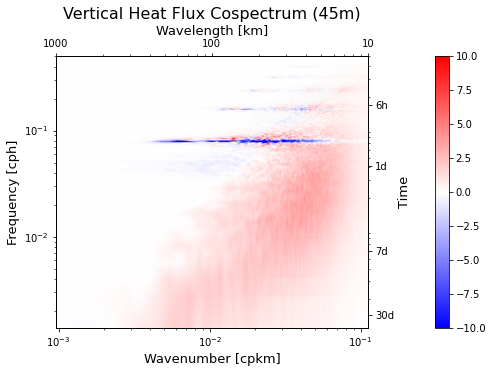

In [36]:
#====================================================
#===================================================
kk = kiso[1:]
omm = om[1:]
#ff = coriolis(38)
#f0 =  0.89e-4
#print(f0)
#kiso = np.logspace(-3,0.,100)

#################
fig = plt.figure(figsize=(8,5))

#fig = plt.figure(figsize=(10,6))
#ax1 = plt.subplot2grid((3,6),(0,1),colspan=2)
#ax2 = plt.subplot2grid((3,6),(1,0),rowspan=2)
#ax3 = plt.subplot2grid((3,6),(1,1),rowspan=2, colspan=2)
ax1 = fig.add_subplot(111)
cs=plt.pcolormesh(kk,omm,60*1*Eiso_units.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='bwr' )
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title('Vertical Heat Flux Cospectrum (45m)', size=16)
plt.xlabel(r'Wavenumber [cpkm]',size=13)
plt.ylabel(r'Frequency [cph]',size=13)
plt.clim([-10,10])
plt.colorbar(pad=0.15)
#ax1.set_ylim([omm[1], omm[-1]])
#ax1.set_xlim([kk[1],1e-1])
#ax3.set_yticks([])
#plt.title('Mode-1',fontweight='bold',size=20)
#

#plt.savefig(PrntOut+figurename+output_format,format='png',
#            dpi=500,bbox_inches='tight')
ax1a = ax1.twiny()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_xlim(1./1000.,1/10.)
ax1a.set_xticks([1/1000.,1/100.,1/10.])
ax1a.set_xticklabels(['1000','100','10'])
ax1a.set_xlabel('Wavelength [km]',size=13)
ax1a = ax1.twinx()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_ylim(1/(24.*40.),1/2.)
ax1a.set_yticks([1/6, 1/24.,1/(24.*7.),1/(24*30.)])
ax1a.set_yticklabels(['6h','1d','7d','30d'])
ax1a.set_ylabel('Time', size=13)
plt.show()


In [54]:
W15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'W', 36,36)
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'Theta', 36,36)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [55]:
W15c = W15.W.compute()
T15c = T15.Theta.compute()

In [56]:
W15_reg = regularizeCoordinates(W15c,'linear',timeunits = 'hours')
T15_reg = regularizeCoordinates(T15c,'linear',timeunits = 'hours')

In [57]:
W15_reg

<xarray.DataArray (time: 4416, xdim: 500, ydim: 500)>
array([[[-1.17893505e-03, -1.31886196e-03, -1.38060329e-03, ...,
          2.59187119e-03,  2.97454093e-03,  2.19032960e-03],
        [-3.42518499e-04, -2.78595253e-04, -7.53402128e-05, ...,
         -1.02521339e-03,  3.10699776e-04,  1.18009304e-03],
        [ 2.04413936e-05,  1.54078254e-04,  1.92294639e-04, ...,
         -2.16373242e-03, -6.78182812e-04,  4.34509238e-05],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          9.87759791e-04,  1.42998528e-03,  1.26115978e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.43719651e-03,  9.56955540e-04,  7.63593125e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.29465968e-03,  2.18191475e-04,  7.84386706e-04]],

       [[-8.44617243e-05, -6.76476979e-04, -1.11571955e-03, ...,
          9.49993788e-04,  1.41024264e-03,  1.81512651e-03],
        [ 1.85380894e-04, -8.82764361e-05, -3.51414812e-04, ...,
         -3.17485712e-04, -5.28758683e-04, -2.70114397e-05],
        [ 2.04281328e-04,  1.26071507e-04, -1.57764793e-04, ...,
         -2.01296480e-03, -1.89971644e-03, -1.09739706e-03],
...
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -5.30127028e-04, -6.75625866e-04, -7.64092198e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.10314251e-03, -7.95619446e-04, -6.46844506e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.12083938e-03, -1.14363595e-03, -5.44194889e-04]],

       [[-1.89393701e-03, -9.94124915e-04, -1.88425125e-04, ...,
         -2.44540133e-05, -1.67452643e-04,  1.48789550e-03],
        [-2.54689949e-03, -2.00785976e-03, -1.56966480e-03, ...,
          6.34305296e-04,  2.34206300e-03,  3.37866461e-03],
        [-1.99188944e-03, -1.35538389e-03, -7.81317591e-04, ...,
          1.13450515e-03,  2.93988548e-03,  3.54929687e-03],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -5.57211228e-04, -8.81819171e-04, -1.20196713e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -9.73674003e-04, -1.24815770e-03, -1.28126913e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -5.84584428e-04, -8.33081198e-04, -1.14291732e-03]]])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 4.413e+03 4.414e+03 4.415e+03
  * xdim     (xdim) float64 0.0 1.738 3.476 5.214 ... 862.0 863.8 865.5 867.2
  * ydim     (ydim) float64 0.0 4.448 8.896 ... 2.211e+03 2.215e+03 2.22e+03

In [58]:
W15_t = xrft.detrend(W15_reg, dim = 'time', detrend_type = 'linear')
W15_txy = xrft.detrend(W15_t, dim = ['xdim','ydim'], detrend_type = 'linear')
T15_t = xrft.detrend(T15_reg, dim = 'time', detrend_type = 'linear')
T15_txy = xrft.detrend(T15_t, dim = ['xdim','ydim'], detrend_type = 'linear')

In [59]:
W15_np = W15_txy.values
W15_np_swap = np.swapaxes(np.swapaxes(W15_np, 0, 1), 1,2)
T15_np = T15_txy.values
T15_np_swap = np.swapaxes(np.swapaxes(T15_np, 0, 1), 1, 2)

In [60]:
dx = W15_txy.xdim.diff('xdim').mean().values
dy = W15_txy.ydim.diff('ydim').mean().values
dt = W15_txy.time.diff('time').mean().values

In [61]:
dt

array(1.)

In [62]:
u = W15_np_swap
v = T15_np_swap

In [63]:
import co_spec

In [64]:
# Preambule
iy,ix,it = u.shape
#print(it,iy,ix)
iaux = (30*24)#(60*24*7)/10 #(7*24)
nt = np.around(it/(iaux),decimals=1)
print(nt)

# Calclate the 3D spectrum
for i in range(int(nt)):
      uaux = u[:,:,i*iaux:i*iaux+iaux]
      vaux = v[:,:,i*iaux:i*iaux+iaux]
      if i == 0:
         Eu,k,l,om, df1, df2, df3 = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
      else:
         Eua,_,_,_,_,_,_ = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
         Eu = Eu + Eua
Eu = Eu/nt
#USE SAME RESOLUTION IN THE DX AND DY!!!

6.1
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993


//nobackup//amondal//Python//Hector_Python_Scripts/co_spec.py:31: RuntimeWarning: invalid value encountered in sqrt
  cospec_rms = np.sqrt((cospec_dens[1:,1:,1:-2].sum()*df1*df2*df3))


before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993


In [65]:
def calc_ispec(k,l,E):
    """ calculates isotropic spectrum from 2D spectrum """

    dk,dl = k[1,]-k[0],l[1]-l[0]
    l,k = np.meshgrid(l,k)
    wv = np.sqrt(k**2 + l**2)

    if k.max()>l.max():
        kmax = l.max()
    else:
        kmax = k.max()

    # create radial wavenumber
    dkr = np.sqrt(dk**2 + dl**2)
    kr =  np.arange(dkr/2.,kmax+dkr,dkr)
    ispec = np.zeros(kr.size)
    #print(ispec.shape)
    #print(kr.shape)
    for i in range(kr.size):
        fkr =  (wv>=kr[i]-dkr/2) & (wv<=kr[i]+dkr/2)
    #    print(fkr.shape)
        dth = np.pi / (fkr.sum()-1)
        ispec[i] = E[fkr].sum() * kr[i] * dth

    return kr, ispec

In [66]:
I = 0
for i in range(om.size-1):
    kiso,Ei = calc_ispec(k,l,Eu[:,:,i])
    if I == 0:
        Eiso = np.empty((len(Ei),om.size))
    Eiso[:,i] = Ei
    I = I + 1

In [67]:
Eiso_units = Eiso*4.2e6# rho Cp

In [68]:
np.isnan(Eiso).sum()

0

In [69]:
#Eiso_units= Eiso#*4.2e6
#Eiso_units.shape

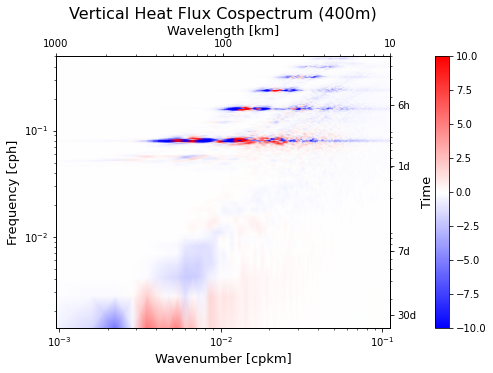

In [70]:
#====================================================
#===================================================
kk = kiso[1:]
omm = om[1:]
#ff = coriolis(38)
#f0 =  0.89e-4
#print(f0)
#kiso = np.logspace(-3,0.,100)

#################
fig = plt.figure(figsize=(8,5))

#fig = plt.figure(figsize=(10,6))
#ax1 = plt.subplot2grid((3,6),(0,1),colspan=2)
#ax2 = plt.subplot2grid((3,6),(1,0),rowspan=2)
#ax3 = plt.subplot2grid((3,6),(1,1),rowspan=2, colspan=2)
ax1 = fig.add_subplot(111)
cs=plt.pcolormesh(kk,omm,60*1*Eiso_units.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='bwr' )
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title('Vertical Heat Flux Cospectrum (400m)', size=16)
plt.xlabel(r'Wavenumber [cpkm]',size=13)
plt.ylabel(r'Frequency [cph]',size=13)
plt.clim([-10,10])
plt.colorbar(pad=0.1)
#ax1.set_ylim([omm[1], omm[-1]])
#ax1.set_xlim([kk[1],1e-1])
#ax3.set_yticks([])
#plt.title('Mode-1',fontweight='bold',size=20)
#

#plt.savefig(PrntOut+figurename+output_format,format='png',
#            dpi=500,bbox_inches='tight')
ax1a = ax1.twiny()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_xlim(1./1000.,1/10.)
ax1a.set_xticks([1/1000.,1/100.,1/10.])
ax1a.set_xticklabels(['1000','100','10'])
ax1a.set_xlabel('Wavelength [km]',size=13)
ax1a = ax1.twinx()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_ylim(1/(24.*40.),1/2.)
ax1a.set_yticks([1/6, 1/24.,1/(24.*7.),1/(24*30.)])
ax1a.set_yticklabels(['6h','1d','7d','30d'])
ax1a.set_ylabel('Time', size=13)
plt.show()



In [4]:
W15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'W', 32,32)
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'Theta', 32,32)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [5]:
W15c = W15.W.compute()
T15c = T15.Theta.compute()

In [6]:
W15_reg = regularizeCoordinates(W15c,'linear',timeunits = 'hours')
T15_reg = regularizeCoordinates(T15c,'linear',timeunits = 'hours')

In [7]:
W15_reg

<xarray.DataArray (time: 4416, xdim: 500, ydim: 500)>
array([[[-5.46183554e-04, -9.85585386e-04, -1.20510743e-03, ...,
          2.20760470e-03,  2.10160296e-03,  1.06293906e-03],
        [-1.40800999e-04, -7.04136328e-05,  9.97485913e-05, ...,
         -1.18610403e-03,  3.87845284e-05,  8.54622456e-04],
        [ 2.08060097e-04,  5.65256923e-04,  7.03095284e-04, ...,
         -2.07484514e-03, -4.82137606e-04,  4.68902057e-04],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          6.57398836e-04,  1.17398426e-03,  1.86362839e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          9.64901701e-04,  1.15894363e-03,  1.66905322e-03],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          1.28885033e-03,  9.43560444e-04,  1.23194861e-03]],

       [[ 1.52480847e-04, -5.55480714e-04, -1.01144484e-03, ...,
          3.51357536e-04,  8.48976080e-04,  1.45556335e-03],
        [ 5.36321895e-04,  1.10143068e-04, -4.27989231e-04, ...,
         -2.07064542e-04, -6.58300007e-04, -2.82792753e-04],
        [ 4.91512474e-04,  3.37914185e-04, -1.11666865e-04, ...,
         -8.80110078e-04, -1.54040242e-03, -7.52938795e-04],
...
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.08380546e-03, -9.37441480e-04, -6.91791764e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.14515692e-03, -4.00068326e-04, -3.08335759e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -4.64115146e-04, -5.67015843e-04, -3.04921705e-04]],

       [[-1.10335439e-03, -4.13629139e-04,  1.35084963e-04, ...,
         -1.97466827e-04, -4.06417093e-04,  5.74643549e-04],
        [-1.99708575e-03, -1.48195750e-03, -1.19335891e-03, ...,
          5.85961039e-04,  2.32507102e-03,  3.08456179e-03],
        [-2.00480642e-03, -1.35458843e-03, -7.17877294e-04, ...,
          1.49433478e-03,  3.52404872e-03,  3.53141362e-03],
        ...,
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.58434664e-03, -1.19810784e-03, -9.05884895e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         -1.05301850e-03, -5.88236959e-04, -6.33878750e-04],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          2.30935824e-04, -1.41696510e-04, -8.06265161e-04]]])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 4.413e+03 4.414e+03 4.415e+03
  * xdim     (xdim) float64 0.0 1.738 3.476 5.214 ... 862.0 863.8 865.5 867.2
  * ydim     (ydim) float64 0.0 4.448 8.896 ... 2.211e+03 2.215e+03 2.22e+03

In [8]:
W15_t = xrft.detrend(W15_reg, dim = 'time', detrend_type = 'linear')
W15_txy = xrft.detrend(W15_t, dim = ['xdim','ydim'], detrend_type = 'linear')
T15_t = xrft.detrend(T15_reg, dim = 'time', detrend_type = 'linear')
T15_txy = xrft.detrend(T15_t, dim = ['xdim','ydim'], detrend_type = 'linear')

In [9]:
W15_np = W15_txy.values
W15_np_swap = np.swapaxes(np.swapaxes(W15_np, 0, 1), 1,2)
T15_np = T15_txy.values
T15_np_swap = np.swapaxes(np.swapaxes(T15_np, 0, 1), 1, 2)

In [10]:
dx = W15_txy.xdim.diff('xdim').mean().values
dy = W15_txy.ydim.diff('ydim').mean().values
dt = W15_txy.time.diff('time').mean().values

In [11]:
dt

array(1.)

In [12]:
u = W15_np_swap
v = T15_np_swap

In [13]:
import co_spec

In [14]:
# Preambule
iy,ix,it = u.shape
#print(it,iy,ix)
iaux = (30*24)#(60*24*7)/10 #(7*24)
nt = np.around(it/(iaux),decimals=1)
print(nt)

# Calclate the 3D spectrum
for i in range(int(nt)):
      uaux = u[:,:,i*iaux:i*iaux+iaux]
      vaux = v[:,:,i*iaux:i*iaux+iaux]
      if i == 0:
         Eu,k,l,om, df1, df2, df3 = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
      else:
         Eua,_,_,_,_,_,_ = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
         Eu = Eu + Eua
Eu = Eu/nt
#USE SAME RESOLUTION IN THE DX AND DY!!!

6.1
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993


In [15]:
def calc_ispec(k,l,E):
    """ calculates isotropic spectrum from 2D spectrum """

    dk,dl = k[1,]-k[0],l[1]-l[0]
    l,k = np.meshgrid(l,k)
    wv = np.sqrt(k**2 + l**2)

    if k.max()>l.max():
        kmax = l.max()
    else:
        kmax = k.max()

    # create radial wavenumber
    dkr = np.sqrt(dk**2 + dl**2)
    kr =  np.arange(dkr/2.,kmax+dkr,dkr)
    ispec = np.zeros(kr.size)
    #print(ispec.shape)
    #print(kr.shape)
    for i in range(kr.size):
        fkr =  (wv>=kr[i]-dkr/2) & (wv<=kr[i]+dkr/2)
    #    print(fkr.shape)
        dth = np.pi / (fkr.sum()-1)
        ispec[i] = E[fkr].sum() * kr[i] * dth

    return kr, ispec

In [16]:
I = 0
for i in range(om.size-1):
    kiso,Ei = calc_ispec(k,l,Eu[:,:,i])
    if I == 0:
        Eiso = np.empty((len(Ei),om.size))
    Eiso[:,i] = Ei
    I = I + 1

In [17]:
Eiso_units = Eiso*4.2e6# rho Cp

In [18]:
np.isnan(Eiso).sum()

0

In [19]:
#Eiso_units= Eiso#*4.2e6
#Eiso_units.shape

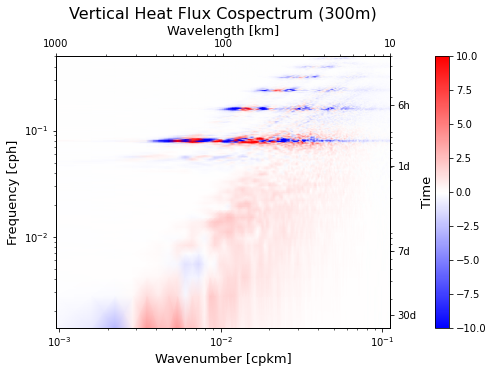

In [20]:
#====================================================
#===================================================
kk = kiso[1:]
omm = om[1:]
#ff = coriolis(38)
#f0 =  0.89e-4
#print(f0)
#kiso = np.logspace(-3,0.,100)

#################
fig = plt.figure(figsize=(8,5))

#fig = plt.figure(figsize=(10,6))
#ax1 = plt.subplot2grid((3,6),(0,1),colspan=2)
#ax2 = plt.subplot2grid((3,6),(1,0),rowspan=2)
#ax3 = plt.subplot2grid((3,6),(1,1),rowspan=2, colspan=2)
ax1 = fig.add_subplot(111)
cs=plt.pcolormesh(kk,omm,60*1*Eiso_units.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='bwr' )
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title('Vertical Heat Flux Cospectrum (300m)', size=16)
plt.xlabel(r'Wavenumber [cpkm]',size=13)
plt.ylabel(r'Frequency [cph]',size=13)
plt.clim([-10,10])
plt.colorbar(pad=0.1)
#ax1.set_ylim([omm[1], omm[-1]])
#ax1.set_xlim([kk[1],1e-1])
#ax3.set_yticks([])
#plt.title('Mode-1',fontweight='bold',size=20)
#

#plt.savefig(PrntOut+figurename+output_format,format='png',
#            dpi=500,bbox_inches='tight')
ax1a = ax1.twiny()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_xlim(1./1000.,1/10.)
ax1a.set_xticks([1/1000.,1/100.,1/10.])
ax1a.set_xticklabels(['1000','100','10'])
ax1a.set_xlabel('Wavelength [km]',size=13)
ax1a = ax1.twinx()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_ylim(1/(24.*40.),1/2.)
ax1a.set_yticks([1/6, 1/24.,1/(24.*7.),1/(24*30.)])
ax1a.set_yticklabels(['6h','1d','7d','30d'])
ax1a.set_ylabel('Time', size=13)
plt.show()



In [21]:
W15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'W', 28,28)
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'Theta', 28,28)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [22]:
W15c = W15.W.compute()
T15c = T15.Theta.compute()

In [23]:
W15_reg = regularizeCoordinates(W15c,'linear',timeunits = 'hours')
T15_reg = regularizeCoordinates(T15c,'linear',timeunits = 'hours')

In [24]:
W15_reg

<xarray.DataArray (time: 4416, xdim: 500, ydim: 500)>
array([[[-4.01694677e-04, -7.61023606e-04, -9.27900313e-04, ...,
          7.31419772e-04,  1.14395190e-03,  2.54157814e-04],
        [-5.68902069e-05,  2.51881633e-04,  3.39103222e-04, ...,
         -1.41478144e-03, -3.18278675e-04,  1.91437110e-04],
        [ 3.30150971e-04,  8.75012018e-04,  8.57241335e-04, ...,
         -1.60525553e-03, -8.73662066e-05,  7.25291145e-04],
        ...,
        [ 9.05447290e-04,  8.23993651e-18,  0.00000000e+00, ...,
         -1.66022859e-04,  5.40348847e-05,  1.44443917e-03],
        [ 6.54027390e-04,  2.05349745e-04,  3.76760255e-18, ...,
         -6.44306012e-04,  4.90232545e-04,  1.80471770e-03],
        [ 1.86500722e-03,  1.66967135e-17,  0.00000000e+00, ...,
         -3.03364184e-04,  1.07174995e-03,  1.59582100e-03]],

       [[ 5.66741437e-06, -5.34902734e-04, -8.46607087e-04, ...,
         -8.32132704e-04,  5.59878710e-04,  1.08150602e-03],
        [ 8.06145137e-04,  5.29383891e-04, -2.24131829e-04, ...,
         -6.76491531e-04, -1.13345240e-03, -7.64993136e-04],
        [ 8.12470214e-04,  6.14868535e-04, -1.98256399e-04, ...,
         -5.94005862e-04, -1.38823874e-03, -8.55827820e-04],
...
        [-1.37618731e-03, -1.25767452e-17,  0.00000000e+00, ...,
         -6.32759125e-04, -5.99358580e-04, -4.85332916e-04],
        [-1.83621875e-03, -1.42421020e-04, -2.60208521e-18, ...,
         -9.86494822e-04, -2.07341218e-04, -1.90584600e-04],
        [ 9.06971400e-04,  8.13151629e-18,  0.00000000e+00, ...,
         -4.29234584e-04, -5.63892128e-04, -4.10572771e-04]],

       [[-5.14475396e-04, -9.08839866e-05,  7.78033573e-05, ...,
         -5.20058966e-05, -2.63992610e-04,  3.08117771e-04],
        [-1.60755939e-03, -1.22894556e-03, -1.00112602e-03, ...,
          5.48869488e-04,  2.00118497e-03,  2.30101263e-03],
        [-1.99501403e-03, -1.36607070e-03, -6.06851943e-04, ...,
          1.68560608e-03,  3.48850503e-03,  3.03046987e-03],
        ...,
        [-1.22968038e-03, -1.10588622e-17,  0.00000000e+00, ...,
         -1.36961066e-03, -9.56727890e-04, -7.80445174e-04],
        [-1.80915918e-03, -1.89070182e-04, -3.46944695e-18, ...,
         -8.94108089e-04, -3.99298733e-04, -4.55675297e-04],
        [ 2.89353047e-04,  2.60208521e-18,  0.00000000e+00, ...,
          1.45401980e-04, -1.49320083e-04, -8.55799066e-04]]])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 4.413e+03 4.414e+03 4.415e+03
  * xdim     (xdim) float64 0.0 1.738 3.476 5.214 ... 862.0 863.8 865.5 867.2
  * ydim     (ydim) float64 0.0 4.448 8.896 ... 2.211e+03 2.215e+03 2.22e+03

In [25]:
W15_t = xrft.detrend(W15_reg, dim = 'time', detrend_type = 'linear')
W15_txy = xrft.detrend(W15_t, dim = ['xdim','ydim'], detrend_type = 'linear')
T15_t = xrft.detrend(T15_reg, dim = 'time', detrend_type = 'linear')
T15_txy = xrft.detrend(T15_t, dim = ['xdim','ydim'], detrend_type = 'linear')

In [26]:
W15_np = W15_txy.values
W15_np_swap = np.swapaxes(np.swapaxes(W15_np, 0, 1), 1,2)
T15_np = T15_txy.values
T15_np_swap = np.swapaxes(np.swapaxes(T15_np, 0, 1), 1, 2)

In [27]:
dx = W15_txy.xdim.diff('xdim').mean().values
dy = W15_txy.ydim.diff('ydim').mean().values
dt = W15_txy.time.diff('time').mean().values

In [28]:
dt

array(1.)

In [29]:
u = W15_np_swap
v = T15_np_swap

In [30]:
import co_spec

In [31]:
# Preambule
iy,ix,it = u.shape
#print(it,iy,ix)
iaux = (30*24)#(60*24*7)/10 #(7*24)
nt = np.around(it/(iaux),decimals=1)
print(nt)

# Calclate the 3D spectrum
for i in range(int(nt)):
      uaux = u[:,:,i*iaux:i*iaux+iaux]
      vaux = v[:,:,i*iaux:i*iaux+iaux]
      if i == 0:
         Eu,k,l,om, df1, df2, df3 = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
      else:
         Eua,_,_,_,_,_,_ = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
         Eu = Eu + Eua
Eu = Eu/nt
#USE SAME RESOLUTION IN THE DX AND DY!!!

6.1
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993


In [32]:
def calc_ispec(k,l,E):
    """ calculates isotropic spectrum from 2D spectrum """

    dk,dl = k[1,]-k[0],l[1]-l[0]
    l,k = np.meshgrid(l,k)
    wv = np.sqrt(k**2 + l**2)

    if k.max()>l.max():
        kmax = l.max()
    else:
        kmax = k.max()

    # create radial wavenumber
    dkr = np.sqrt(dk**2 + dl**2)
    kr =  np.arange(dkr/2.,kmax+dkr,dkr)
    ispec = np.zeros(kr.size)
    #print(ispec.shape)
    #print(kr.shape)
    for i in range(kr.size):
        fkr =  (wv>=kr[i]-dkr/2) & (wv<=kr[i]+dkr/2)
    #    print(fkr.shape)
        dth = np.pi / (fkr.sum()-1)
        ispec[i] = E[fkr].sum() * kr[i] * dth

    return kr, ispec

In [33]:
I = 0
for i in range(om.size-1):
    kiso,Ei = calc_ispec(k,l,Eu[:,:,i])
    if I == 0:
        Eiso = np.empty((len(Ei),om.size))
    Eiso[:,i] = Ei
    I = I + 1

In [34]:
Eiso_units = Eiso*4.2e6# rho Cp

In [35]:
np.isnan(Eiso).sum()

0

In [36]:
#Eiso_units= Eiso#*4.2e6
#Eiso_units.shape

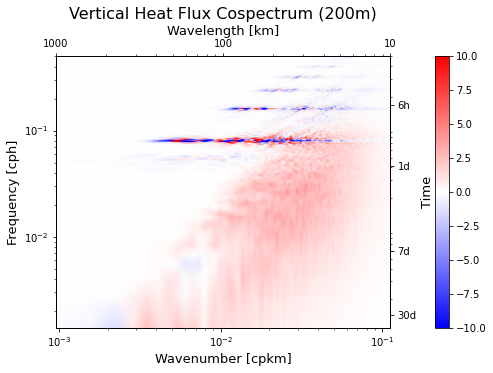

In [37]:
#====================================================
#===================================================
kk = kiso[1:]
omm = om[1:]
#ff = coriolis(38)
#f0 =  0.89e-4
#print(f0)
#kiso = np.logspace(-3,0.,100)

#################
fig = plt.figure(figsize=(8,5))

#fig = plt.figure(figsize=(10,6))
#ax1 = plt.subplot2grid((3,6),(0,1),colspan=2)
#ax2 = plt.subplot2grid((3,6),(1,0),rowspan=2)
#ax3 = plt.subplot2grid((3,6),(1,1),rowspan=2, colspan=2)
ax1 = fig.add_subplot(111)
cs=plt.pcolormesh(kk,omm,60*1*Eiso_units.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='bwr' )
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title('Vertical Heat Flux Cospectrum (200m)', size=16)
plt.xlabel(r'Wavenumber [cpkm]',size=13)
plt.ylabel(r'Frequency [cph]',size=13)
plt.clim([-10,10])
plt.colorbar(pad=0.1)
#ax1.set_ylim([omm[1], omm[-1]])
#ax1.set_xlim([kk[1],1e-1])
#ax3.set_yticks([])
#plt.title('Mode-1',fontweight='bold',size=20)
#

#plt.savefig(PrntOut+figurename+output_format,format='png',
#            dpi=500,bbox_inches='tight')
ax1a = ax1.twiny()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_xlim(1./1000.,1/10.)
ax1a.set_xticks([1/1000.,1/100.,1/10.])
ax1a.set_xticklabels(['1000','100','10'])
ax1a.set_xlabel('Wavelength [km]',size=13)
ax1a = ax1.twinx()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_ylim(1/(24.*40.),1/2.)
ax1a.set_yticks([1/6, 1/24.,1/(24.*7.),1/(24*30.)])
ax1a.set_yticklabels(['6h','1d','7d','30d'])
ax1a.set_ylabel('Time', size=13)
plt.show()



I'll calculate just the spring time spectra (March through the end of May)

In [31]:
W15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'W', 15,15)
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'Theta', 15,15)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [34]:
T15

<xarray.Dataset>
Dimensions:  (lat: 500, lon: 500, time: 4416)
Coordinates:
  * lat      (lat) float64 23.0 23.04 23.08 23.12 ... 42.84 42.88 42.92 42.96
  * lon      (lon) float64 -67.0 -66.96 -66.92 -66.88 ... -47.12 -47.08 -47.04
Dimensions without coordinates: time
Data variables:
    Theta    (time, lat, lon) float64 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>

In [35]:
W15c = W15.W.compute()[0:int(W15.W.time.size / 2)]
T15c = T15.Theta.compute()[0:int(T15.Theta.time.size / 2)]

In [36]:
W15_reg = regularizeCoordinates(W15c,'linear',timeunits = 'hours')
T15_reg = regularizeCoordinates(T15c,'linear',timeunits = 'hours')

In [37]:
T15_reg.time.size

2208

In [38]:
W15_t = xrft.detrend(W15_reg, dim = 'time', detrend_type = 'linear')
W15_txy = xrft.detrend(W15_t, dim = ['xdim','ydim'], detrend_type = 'linear')
T15_t = xrft.detrend(T15_reg, dim = 'time', detrend_type = 'linear')
T15_txy = xrft.detrend(T15_t, dim = ['xdim','ydim'], detrend_type = 'linear')

In [39]:
W15_np = W15_txy.values
W15_np_swap = np.swapaxes(np.swapaxes(W15_np, 0, 1), 1,2)
T15_np = T15_txy.values
T15_np_swap = np.swapaxes(np.swapaxes(T15_np, 0, 1), 1, 2)

In [40]:
dx = W15_txy.xdim.diff('xdim').mean().values
dy = W15_txy.ydim.diff('ydim').mean().values
dt = W15_txy.time.diff('time').mean().values

In [41]:
dt

array(1.)

In [42]:
u = W15_np_swap
v = T15_np_swap

In [43]:
import co_spec

In [44]:
# Preambule
iy,ix,it = u.shape
#print(it,iy,ix)
iaux = (30*24)#(60*24*7)/10 #(7*24)
nt = np.around(it/(iaux),decimals=1)
print(nt)

# Calclate the 3D spectrum
for i in range(int(nt)):
      uaux = u[:,:,i*iaux:i*iaux+iaux]
      vaux = v[:,:,i*iaux:i*iaux+iaux]
      if i == 0:
         Eu,k,l,om, df1, df2, df3 = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
      else:
         Eua,_,_,_,_,_,_ = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
         Eu = Eu + Eua
Eu = Eu/nt
#USE SAME RESOLUTION IN THE DX AND DY!!!

3.1
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993


In [45]:
def calc_ispec(k,l,E):
    """ calculates isotropic spectrum from 2D spectrum """

    dk,dl = k[1,]-k[0],l[1]-l[0]
    l,k = np.meshgrid(l,k)
    wv = np.sqrt(k**2 + l**2)

    if k.max()>l.max():
        kmax = l.max()
    else:
        kmax = k.max()

    # create radial wavenumber
    dkr = np.sqrt(dk**2 + dl**2)
    kr =  np.arange(dkr/2.,kmax+dkr,dkr)
    ispec = np.zeros(kr.size)
    #print(ispec.shape)
    #print(kr.shape)
    for i in range(kr.size):
        fkr =  (wv>=kr[i]-dkr/2) & (wv<=kr[i]+dkr/2)
    #    print(fkr.shape)
        dth = np.pi / (fkr.sum()-1)
        ispec[i] = E[fkr].sum() * kr[i] * dth

    return kr, ispec

In [46]:
I = 0
for i in range(om.size-1):
    kiso,Ei = calc_ispec(k,l,Eu[:,:,i])
    if I == 0:
        Eiso = np.empty((len(Ei),om.size))
    Eiso[:,i] = Ei
    I = I + 1

In [47]:
Eiso_units = Eiso*4.2e6# rho Cp

<ipython-input-47-2561f5a81033>:1: RuntimeWarning: overflow encountered in multiply
  Eiso_units = Eiso*4.2e6# rho Cp


In [48]:
np.isnan(Eiso).sum()

16

In [49]:
#Eiso_units= Eiso#*4.2e6
#Eiso_units.shape

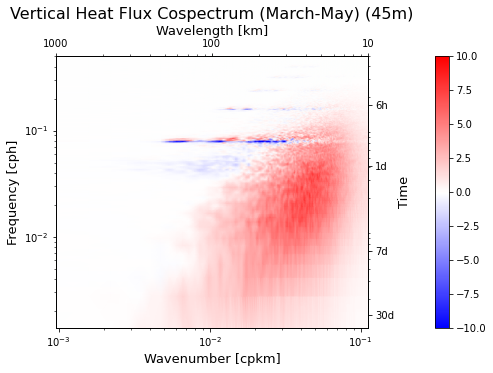

In [50]:
#====================================================
#===================================================
kk = kiso[1:]
omm = om[1:]
#ff = coriolis(38)
#f0 =  0.89e-4
#print(f0)
#kiso = np.logspace(-3,0.,100)

#################
fig = plt.figure(figsize=(8,5))

#fig = plt.figure(figsize=(10,6))
#ax1 = plt.subplot2grid((3,6),(0,1),colspan=2)
#ax2 = plt.subplot2grid((3,6),(1,0),rowspan=2)
#ax3 = plt.subplot2grid((3,6),(1,1),rowspan=2, colspan=2)
ax1 = fig.add_subplot(111)
cs=plt.pcolormesh(kk,omm,60*1*Eiso_units.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='bwr' )
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title('Vertical Heat Flux Cospectrum (March-May) (45m)', size=16)
plt.xlabel(r'Wavenumber [cpkm]',size=13)
plt.ylabel(r'Frequency [cph]',size=13)
plt.clim([-10,10])
plt.colorbar(pad=0.15)
#ax1.set_ylim([omm[1], omm[-1]])
#ax1.set_xlim([kk[1],1e-1])
#ax3.set_yticks([])
#plt.title('Mode-1',fontweight='bold',size=20)
#

#plt.savefig(PrntOut+figurename+output_format,format='png',
#            dpi=500,bbox_inches='tight')
ax1a = ax1.twiny()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_xlim(1./1000.,1/10.)
ax1a.set_xticks([1/1000.,1/100.,1/10.])
ax1a.set_xticklabels(['1000','100','10'])
ax1a.set_xlabel('Wavelength [km]',size=13)
ax1a = ax1.twinx()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_ylim(1/(24.*40.),1/2.)
ax1a.set_yticks([1/6, 1/24.,1/(24.*7.),1/(24*30.)])
ax1a.set_yticklabels(['6h','1d','7d','30d'])
ax1a.set_ylabel('Time', size=13)
plt.show()


In [3]:
W15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'W', 28,28)
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'Theta', 28,28)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [4]:
W15c = W15.W.compute()[0:int(W15.W.time.size / 2)]
T15c = T15.Theta.compute()[0:int(T15.Theta.time.size / 2)]

In [5]:
W15_reg = regularizeCoordinates(W15c,'linear',timeunits = 'hours')
T15_reg = regularizeCoordinates(T15c,'linear',timeunits = 'hours')

In [6]:
W15_t = xrft.detrend(W15_reg, dim = 'time', detrend_type = 'linear')
W15_txy = xrft.detrend(W15_t, dim = ['xdim','ydim'], detrend_type = 'linear')
T15_t = xrft.detrend(T15_reg, dim = 'time', detrend_type = 'linear')
T15_txy = xrft.detrend(T15_t, dim = ['xdim','ydim'], detrend_type = 'linear')

In [7]:
W15_np = W15_txy.values
W15_np_swap = np.swapaxes(np.swapaxes(W15_np, 0, 1), 1,2)
T15_np = T15_txy.values
T15_np_swap = np.swapaxes(np.swapaxes(T15_np, 0, 1), 1, 2)

In [8]:
dx = W15_txy.xdim.diff('xdim').mean().values
dy = W15_txy.ydim.diff('ydim').mean().values
dt = W15_txy.time.diff('time').mean().values

In [9]:
dt

array(1.)

In [10]:
u = W15_np_swap
v = T15_np_swap

In [11]:
import co_spec

In [12]:
# Preambule
iy,ix,it = u.shape
#print(it,iy,ix)
iaux = (30*24)#(60*24*7)/10 #(7*24)
nt = np.around(it/(iaux),decimals=1)
print(nt)

# Calclate the 3D spectrum
for i in range(int(nt)):
      uaux = u[:,:,i*iaux:i*iaux+iaux]
      vaux = v[:,:,i*iaux:i*iaux+iaux]
      if i == 0:
         Eu,k,l,om, df1, df2, df3 = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
      else:
         Eua,_,_,_,_,_,_ = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
         Eu = Eu + Eua
Eu = Eu/nt
#USE SAME RESOLUTION IN THE DX AND DY!!!

3.1
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993


In [13]:
def calc_ispec(k,l,E):
    """ calculates isotropic spectrum from 2D spectrum """

    dk,dl = k[1,]-k[0],l[1]-l[0]
    l,k = np.meshgrid(l,k)
    wv = np.sqrt(k**2 + l**2)

    if k.max()>l.max():
        kmax = l.max()
    else:
        kmax = k.max()

    # create radial wavenumber
    dkr = np.sqrt(dk**2 + dl**2)
    kr =  np.arange(dkr/2.,kmax+dkr,dkr)
    ispec = np.zeros(kr.size)
    #print(ispec.shape)
    #print(kr.shape)
    for i in range(kr.size):
        fkr =  (wv>=kr[i]-dkr/2) & (wv<=kr[i]+dkr/2)
    #    print(fkr.shape)
        dth = np.pi / (fkr.sum()-1)
        ispec[i] = E[fkr].sum() * kr[i] * dth

    return kr, ispec

In [14]:
I = 0
for i in range(om.size-1):
    kiso,Ei = calc_ispec(k,l,Eu[:,:,i])
    if I == 0:
        Eiso = np.empty((len(Ei),om.size))
    Eiso[:,i] = Ei
    I = I + 1

In [15]:
Eiso_units = Eiso*4.2e6# rho Cp

In [16]:
np.isnan(Eiso).sum()

0

In [17]:
#Eiso_units= Eiso#*4.2e6
#Eiso_units.shape

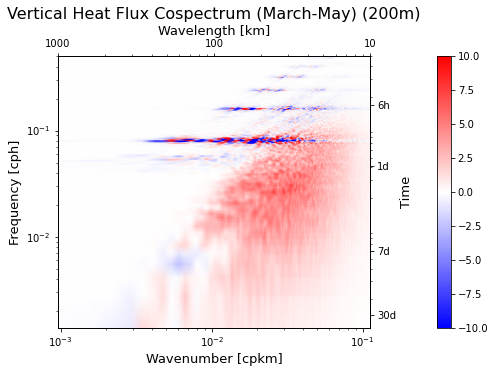

In [18]:
#====================================================
#===================================================
kk = kiso[1:]
omm = om[1:]
#ff = coriolis(38)
#f0 =  0.89e-4
#print(f0)
#kiso = np.logspace(-3,0.,100)

#################
fig = plt.figure(figsize=(8,5))

#fig = plt.figure(figsize=(10,6))
#ax1 = plt.subplot2grid((3,6),(0,1),colspan=2)
#ax2 = plt.subplot2grid((3,6),(1,0),rowspan=2)
#ax3 = plt.subplot2grid((3,6),(1,1),rowspan=2, colspan=2)
ax1 = fig.add_subplot(111)
cs=plt.pcolormesh(kk,omm,60*1*Eiso_units.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='bwr' )
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title('Vertical Heat Flux Cospectrum (March-May) (200m)', size=16)
plt.xlabel(r'Wavenumber [cpkm]',size=13)
plt.ylabel(r'Frequency [cph]',size=13)
plt.clim([-10,10])
plt.colorbar(pad=0.15)
#ax1.set_ylim([omm[1], omm[-1]])
#ax1.set_xlim([kk[1],1e-1])
#ax3.set_yticks([])
#plt.title('Mode-1',fontweight='bold',size=20)
#

#plt.savefig(PrntOut+figurename+output_format,format='png',
#            dpi=500,bbox_inches='tight')
ax1a = ax1.twiny()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_xlim(1./1000.,1/10.)
ax1a.set_xticks([1/1000.,1/100.,1/10.])
ax1a.set_xticklabels(['1000','100','10'])
ax1a.set_xlabel('Wavelength [km]',size=13)
ax1a = ax1.twinx()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_ylim(1/(24.*40.),1/2.)
ax1a.set_yticks([1/6, 1/24.,1/(24.*7.),1/(24*30.)])
ax1a.set_yticklabels(['6h','1d','7d','30d'])
ax1a.set_ylabel('Time', size=13)
plt.show()


In [19]:
W15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'W', 32,32)
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'Theta', 32,32)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [20]:
W15c = W15.W.compute()[0:int(W15.W.time.size / 2)]
T15c = T15.Theta.compute()[0:int(T15.Theta.time.size / 2)]

In [21]:
W15_reg = regularizeCoordinates(W15c,'linear',timeunits = 'hours')
T15_reg = regularizeCoordinates(T15c,'linear',timeunits = 'hours')

In [22]:
W15_t = xrft.detrend(W15_reg, dim = 'time', detrend_type = 'linear')
W15_txy = xrft.detrend(W15_t, dim = ['xdim','ydim'], detrend_type = 'linear')
T15_t = xrft.detrend(T15_reg, dim = 'time', detrend_type = 'linear')
T15_txy = xrft.detrend(T15_t, dim = ['xdim','ydim'], detrend_type = 'linear')

In [23]:
W15_np = W15_txy.values
W15_np_swap = np.swapaxes(np.swapaxes(W15_np, 0, 1), 1,2)
T15_np = T15_txy.values
T15_np_swap = np.swapaxes(np.swapaxes(T15_np, 0, 1), 1, 2)

In [24]:
dx = W15_txy.xdim.diff('xdim').mean().values
dy = W15_txy.ydim.diff('ydim').mean().values
dt = W15_txy.time.diff('time').mean().values

In [25]:
dt

array(1.)

In [26]:
u = W15_np_swap
v = T15_np_swap

In [27]:
import co_spec

In [28]:
# Preambule
iy,ix,it = u.shape
#print(it,iy,ix)
iaux = (30*24)#(60*24*7)/10 #(7*24)
nt = np.around(it/(iaux),decimals=1)
print(nt)

# Calclate the 3D spectrum
for i in range(int(nt)):
      uaux = u[:,:,i*iaux:i*iaux+iaux]
      vaux = v[:,:,i*iaux:i*iaux+iaux]
      if i == 0:
         Eu,k,l,om, df1, df2, df3 = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
      else:
         Eua,_,_,_,_,_,_ = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
         Eu = Eu + Eua
Eu = Eu/nt
#USE SAME RESOLUTION IN THE DX AND DY!!!

3.1
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993


In [29]:
def calc_ispec(k,l,E):
    """ calculates isotropic spectrum from 2D spectrum """

    dk,dl = k[1,]-k[0],l[1]-l[0]
    l,k = np.meshgrid(l,k)
    wv = np.sqrt(k**2 + l**2)

    if k.max()>l.max():
        kmax = l.max()
    else:
        kmax = k.max()

    # create radial wavenumber
    dkr = np.sqrt(dk**2 + dl**2)
    kr =  np.arange(dkr/2.,kmax+dkr,dkr)
    ispec = np.zeros(kr.size)
    #print(ispec.shape)
    #print(kr.shape)
    for i in range(kr.size):
        fkr =  (wv>=kr[i]-dkr/2) & (wv<=kr[i]+dkr/2)
    #    print(fkr.shape)
        dth = np.pi / (fkr.sum()-1)
        ispec[i] = E[fkr].sum() * kr[i] * dth

    return kr, ispec

In [30]:
I = 0
for i in range(om.size-1):
    kiso,Ei = calc_ispec(k,l,Eu[:,:,i])
    if I == 0:
        Eiso = np.empty((len(Ei),om.size))
    Eiso[:,i] = Ei
    I = I + 1

In [31]:
Eiso_units = Eiso*4.2e6# rho Cp

In [32]:
np.isnan(Eiso).sum()

0

In [33]:
#Eiso_units= Eiso#*4.2e6
#Eiso_units.shape

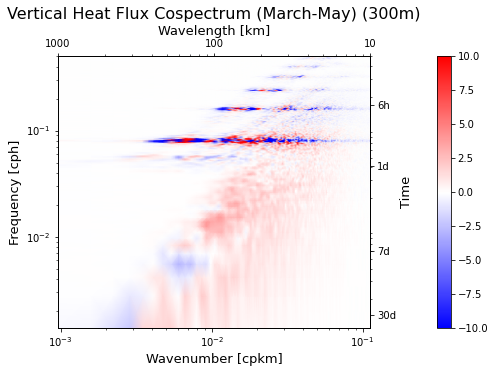

In [34]:
#====================================================
#===================================================
kk = kiso[1:]
omm = om[1:]
#ff = coriolis(38)
#f0 =  0.89e-4
#print(f0)
#kiso = np.logspace(-3,0.,100)

#################
fig = plt.figure(figsize=(8,5))

#fig = plt.figure(figsize=(10,6))
#ax1 = plt.subplot2grid((3,6),(0,1),colspan=2)
#ax2 = plt.subplot2grid((3,6),(1,0),rowspan=2)
#ax3 = plt.subplot2grid((3,6),(1,1),rowspan=2, colspan=2)
ax1 = fig.add_subplot(111)
cs=plt.pcolormesh(kk,omm,60*1*Eiso_units.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='bwr' )
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title('Vertical Heat Flux Cospectrum (March-May) (300m)', size=16)
plt.xlabel(r'Wavenumber [cpkm]',size=13)
plt.ylabel(r'Frequency [cph]',size=13)
plt.clim([-10,10])
plt.colorbar(pad=0.15)
#ax1.set_ylim([omm[1], omm[-1]])
#ax1.set_xlim([kk[1],1e-1])
#ax3.set_yticks([])
#plt.title('Mode-1',fontweight='bold',size=20)
#

#plt.savefig(PrntOut+figurename+output_format,format='png',
#            dpi=500,bbox_inches='tight')
ax1a = ax1.twiny()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_xlim(1./1000.,1/10.)
ax1a.set_xticks([1/1000.,1/100.,1/10.])
ax1a.set_xticklabels(['1000','100','10'])
ax1a.set_xlabel('Wavelength [km]',size=13)
ax1a = ax1.twinx()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_ylim(1/(24.*40.),1/2.)
ax1a.set_yticks([1/6, 1/24.,1/(24.*7.),1/(24*30.)])
ax1a.set_yticklabels(['6h','1d','7d','30d'])
ax1a.set_ylabel('Time', size=13)
plt.show()


In [35]:
W15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'W', 36,36)
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'Theta', 36,36)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [36]:
W15c = W15.W.compute()[0:int(W15.W.time.size / 2)]
T15c = T15.Theta.compute()[0:int(T15.Theta.time.size / 2)]

In [37]:
W15_reg = regularizeCoordinates(W15c,'linear',timeunits = 'hours')
T15_reg = regularizeCoordinates(T15c,'linear',timeunits = 'hours')

In [38]:
W15_t = xrft.detrend(W15_reg, dim = 'time', detrend_type = 'linear')
W15_txy = xrft.detrend(W15_t, dim = ['xdim','ydim'], detrend_type = 'linear')
T15_t = xrft.detrend(T15_reg, dim = 'time', detrend_type = 'linear')
T15_txy = xrft.detrend(T15_t, dim = ['xdim','ydim'], detrend_type = 'linear')

In [39]:
W15_np = W15_txy.values
W15_np_swap = np.swapaxes(np.swapaxes(W15_np, 0, 1), 1,2)
T15_np = T15_txy.values
T15_np_swap = np.swapaxes(np.swapaxes(T15_np, 0, 1), 1, 2)

In [40]:
dx = W15_txy.xdim.diff('xdim').mean().values
dy = W15_txy.ydim.diff('ydim').mean().values
dt = W15_txy.time.diff('time').mean().values

In [41]:
dt

array(1.)

In [42]:
u = W15_np_swap
v = T15_np_swap

In [43]:
import co_spec

In [44]:
# Preambule
iy,ix,it = u.shape
#print(it,iy,ix)
iaux = (30*24)#(60*24*7)/10 #(7*24)
nt = np.around(it/(iaux),decimals=1)
print(nt)

# Calclate the 3D spectrum
for i in range(int(nt)):
      uaux = u[:,:,i*iaux:i*iaux+iaux]
      vaux = v[:,:,i*iaux:i*iaux+iaux]
      if i == 0:
         Eu,k,l,om, df1, df2, df3 = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
      else:
         Eua,_,_,_,_,_,_ = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
         Eu = Eu + Eua
Eu = Eu/nt
#USE SAME RESOLUTION IN THE DX AND DY!!!

3.1
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993


In [45]:
def calc_ispec(k,l,E):
    """ calculates isotropic spectrum from 2D spectrum """

    dk,dl = k[1,]-k[0],l[1]-l[0]
    l,k = np.meshgrid(l,k)
    wv = np.sqrt(k**2 + l**2)

    if k.max()>l.max():
        kmax = l.max()
    else:
        kmax = k.max()

    # create radial wavenumber
    dkr = np.sqrt(dk**2 + dl**2)
    kr =  np.arange(dkr/2.,kmax+dkr,dkr)
    ispec = np.zeros(kr.size)
    #print(ispec.shape)
    #print(kr.shape)
    for i in range(kr.size):
        fkr =  (wv>=kr[i]-dkr/2) & (wv<=kr[i]+dkr/2)
    #    print(fkr.shape)
        dth = np.pi / (fkr.sum()-1)
        ispec[i] = E[fkr].sum() * kr[i] * dth

    return kr, ispec

In [46]:
I = 0
for i in range(om.size-1):
    kiso,Ei = calc_ispec(k,l,Eu[:,:,i])
    if I == 0:
        Eiso = np.empty((len(Ei),om.size))
    Eiso[:,i] = Ei
    I = I + 1

In [47]:
Eiso_units = Eiso*4.2e6# rho Cp

In [48]:
np.isnan(Eiso).sum()

0

In [49]:
#Eiso_units= Eiso#*4.2e6
#Eiso_units.shape

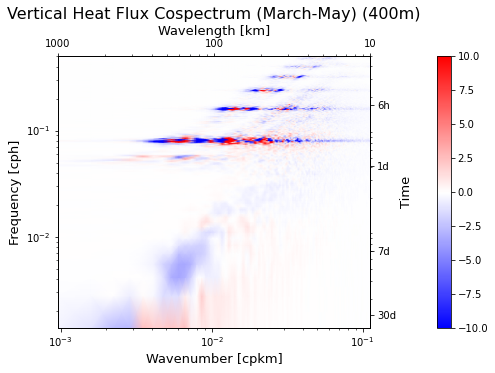

In [50]:
#====================================================
#===================================================
kk = kiso[1:]
omm = om[1:]
#ff = coriolis(38)
#f0 =  0.89e-4
#print(f0)
#kiso = np.logspace(-3,0.,100)

#################
fig = plt.figure(figsize=(8,5))

#fig = plt.figure(figsize=(10,6))
#ax1 = plt.subplot2grid((3,6),(0,1),colspan=2)
#ax2 = plt.subplot2grid((3,6),(1,0),rowspan=2)
#ax3 = plt.subplot2grid((3,6),(1,1),rowspan=2, colspan=2)
ax1 = fig.add_subplot(111)
cs=plt.pcolormesh(kk,omm,60*1*Eiso_units.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='bwr' )
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title('Vertical Heat Flux Cospectrum (March-May) (400m)', size=16)
plt.xlabel(r'Wavenumber [cpkm]',size=13)
plt.ylabel(r'Frequency [cph]',size=13)
plt.clim([-10,10])
plt.colorbar(pad=0.15)
#ax1.set_ylim([omm[1], omm[-1]])
#ax1.set_xlim([kk[1],1e-1])
#ax3.set_yticks([])
#plt.title('Mode-1',fontweight='bold',size=20)
#

#plt.savefig(PrntOut+figurename+output_format,format='png',
#            dpi=500,bbox_inches='tight')
ax1a = ax1.twiny()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_xlim(1./1000.,1/10.)
ax1a.set_xticks([1/1000.,1/100.,1/10.])
ax1a.set_xticklabels(['1000','100','10'])
ax1a.set_xlabel('Wavelength [km]',size=13)
ax1a = ax1.twinx()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_ylim(1/(24.*40.),1/2.)
ax1a.set_yticks([1/6, 1/24.,1/(24.*7.),1/(24*30.)])
ax1a.set_yticklabels(['6h','1d','7d','30d'])
ax1a.set_ylabel('Time', size=13)
plt.show()


In [51]:
W15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'W', 15,15)
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'Theta', 15,15)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [52]:
W15c = W15.W.compute()[int(W15.W.time.size / 2):]
T15c = T15.Theta.compute()[int(T15.Theta.time.size / 2):]

In [53]:
W15_reg = regularizeCoordinates(W15c,'linear',timeunits = 'hours')
T15_reg = regularizeCoordinates(T15c,'linear',timeunits = 'hours')

In [54]:
T15_reg.time.size

2208

In [55]:
W15_t = xrft.detrend(W15_reg, dim = 'time', detrend_type = 'linear')
W15_txy = xrft.detrend(W15_t, dim = ['xdim','ydim'], detrend_type = 'linear')
T15_t = xrft.detrend(T15_reg, dim = 'time', detrend_type = 'linear')
T15_txy = xrft.detrend(T15_t, dim = ['xdim','ydim'], detrend_type = 'linear')

In [56]:
W15_np = W15_txy.values
W15_np_swap = np.swapaxes(np.swapaxes(W15_np, 0, 1), 1,2)
T15_np = T15_txy.values
T15_np_swap = np.swapaxes(np.swapaxes(T15_np, 0, 1), 1, 2)

In [57]:
dx = W15_txy.xdim.diff('xdim').mean().values
dy = W15_txy.ydim.diff('ydim').mean().values
dt = W15_txy.time.diff('time').mean().values

In [58]:
dt

array(1.)

In [59]:
u = W15_np_swap
v = T15_np_swap

In [60]:
import co_spec

In [61]:
# Preambule
iy,ix,it = u.shape
#print(it,iy,ix)
iaux = (30*24)#(60*24*7)/10 #(7*24)
nt = np.around(it/(iaux),decimals=1)
print(nt)

# Calclate the 3D spectrum
for i in range(int(nt)):
      uaux = u[:,:,i*iaux:i*iaux+iaux]
      vaux = v[:,:,i*iaux:i*iaux+iaux]
      if i == 0:
         Eu,k,l,om, df1, df2, df3 = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
      else:
         Eua,_,_,_,_,_,_ = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
         Eu = Eu + Eua
Eu = Eu/nt
#USE SAME RESOLUTION IN THE DX AND DY!!!

3.1
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993


In [62]:
def calc_ispec(k,l,E):
    """ calculates isotropic spectrum from 2D spectrum """

    dk,dl = k[1,]-k[0],l[1]-l[0]
    l,k = np.meshgrid(l,k)
    wv = np.sqrt(k**2 + l**2)

    if k.max()>l.max():
        kmax = l.max()
    else:
        kmax = k.max()

    # create radial wavenumber
    dkr = np.sqrt(dk**2 + dl**2)
    kr =  np.arange(dkr/2.,kmax+dkr,dkr)
    ispec = np.zeros(kr.size)
    #print(ispec.shape)
    #print(kr.shape)
    for i in range(kr.size):
        fkr =  (wv>=kr[i]-dkr/2) & (wv<=kr[i]+dkr/2)
    #    print(fkr.shape)
        dth = np.pi / (fkr.sum()-1)
        ispec[i] = E[fkr].sum() * kr[i] * dth

    return kr, ispec

In [63]:
I = 0
for i in range(om.size-1):
    kiso,Ei = calc_ispec(k,l,Eu[:,:,i])
    if I == 0:
        Eiso = np.empty((len(Ei),om.size))
    Eiso[:,i] = Ei
    I = I + 1

In [64]:
Eiso_units = Eiso*4.2e6# rho Cp

In [65]:
np.isnan(Eiso).sum()

0

In [66]:
#Eiso_units= Eiso#*4.2e6
#Eiso_units.shape

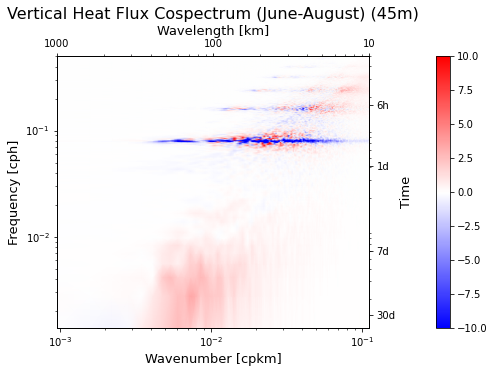

In [67]:
#====================================================
#===================================================
kk = kiso[1:]
omm = om[1:]
#ff = coriolis(38)
#f0 =  0.89e-4
#print(f0)
#kiso = np.logspace(-3,0.,100)

#################
fig = plt.figure(figsize=(8,5))

#fig = plt.figure(figsize=(10,6))
#ax1 = plt.subplot2grid((3,6),(0,1),colspan=2)
#ax2 = plt.subplot2grid((3,6),(1,0),rowspan=2)
#ax3 = plt.subplot2grid((3,6),(1,1),rowspan=2, colspan=2)
ax1 = fig.add_subplot(111)
cs=plt.pcolormesh(kk,omm,60*1*Eiso_units.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='bwr' )
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title('Vertical Heat Flux Cospectrum (June-August) (45m)', size=16)
plt.xlabel(r'Wavenumber [cpkm]',size=13)
plt.ylabel(r'Frequency [cph]',size=13)
plt.clim([-10,10])
plt.colorbar(pad=0.15)
#ax1.set_ylim([omm[1], omm[-1]])
#ax1.set_xlim([kk[1],1e-1])
#ax3.set_yticks([])
#plt.title('Mode-1',fontweight='bold',size=20)
#

#plt.savefig(PrntOut+figurename+output_format,format='png',
#            dpi=500,bbox_inches='tight')
ax1a = ax1.twiny()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_xlim(1./1000.,1/10.)
ax1a.set_xticks([1/1000.,1/100.,1/10.])
ax1a.set_xticklabels(['1000','100','10'])
ax1a.set_xlabel('Wavelength [km]',size=13)
ax1a = ax1.twinx()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_ylim(1/(24.*40.),1/2.)
ax1a.set_yticks([1/6, 1/24.,1/(24.*7.),1/(24*30.)])
ax1a.set_yticklabels(['6h','1d','7d','30d'])
ax1a.set_ylabel('Time', size=13)
plt.show()


In [68]:
W15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'W', 28,28)
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'Theta', 28, 28)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [69]:
W15c = W15.W.compute()[int(W15.W.time.size / 2):]
T15c = T15.Theta.compute()[int(T15.Theta.time.size / 2):]

In [70]:
W15_reg = regularizeCoordinates(W15c,'linear',timeunits = 'hours')
T15_reg = regularizeCoordinates(T15c,'linear',timeunits = 'hours')

In [71]:
T15_reg.time.size

2208

In [72]:
W15_t = xrft.detrend(W15_reg, dim = 'time', detrend_type = 'linear')
W15_txy = xrft.detrend(W15_t, dim = ['xdim','ydim'], detrend_type = 'linear')
T15_t = xrft.detrend(T15_reg, dim = 'time', detrend_type = 'linear')
T15_txy = xrft.detrend(T15_t, dim = ['xdim','ydim'], detrend_type = 'linear')

In [73]:
W15_np = W15_txy.values
W15_np_swap = np.swapaxes(np.swapaxes(W15_np, 0, 1), 1,2)
T15_np = T15_txy.values
T15_np_swap = np.swapaxes(np.swapaxes(T15_np, 0, 1), 1, 2)

In [74]:
dx = W15_txy.xdim.diff('xdim').mean().values
dy = W15_txy.ydim.diff('ydim').mean().values
dt = W15_txy.time.diff('time').mean().values

In [75]:
dt

array(1.)

In [76]:
u = W15_np_swap
v = T15_np_swap

In [77]:
import co_spec

In [78]:
# Preambule
iy,ix,it = u.shape
#print(it,iy,ix)
iaux = (30*24)#(60*24*7)/10 #(7*24)
nt = np.around(it/(iaux),decimals=1)
print(nt)

# Calclate the 3D spectrum
for i in range(int(nt)):
      uaux = u[:,:,i*iaux:i*iaux+iaux]
      vaux = v[:,:,i*iaux:i*iaux+iaux]
      if i == 0:
         Eu,k,l,om, df1, df2, df3 = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
      else:
         Eua,_,_,_,_,_,_ = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
         Eu = Eu + Eua
Eu = Eu/nt
#USE SAME RESOLUTION IN THE DX AND DY!!!

3.1
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993


In [79]:
def calc_ispec(k,l,E):
    """ calculates isotropic spectrum from 2D spectrum """

    dk,dl = k[1,]-k[0],l[1]-l[0]
    l,k = np.meshgrid(l,k)
    wv = np.sqrt(k**2 + l**2)

    if k.max()>l.max():
        kmax = l.max()
    else:
        kmax = k.max()

    # create radial wavenumber
    dkr = np.sqrt(dk**2 + dl**2)
    kr =  np.arange(dkr/2.,kmax+dkr,dkr)
    ispec = np.zeros(kr.size)
    #print(ispec.shape)
    #print(kr.shape)
    for i in range(kr.size):
        fkr =  (wv>=kr[i]-dkr/2) & (wv<=kr[i]+dkr/2)
    #    print(fkr.shape)
        dth = np.pi / (fkr.sum()-1)
        ispec[i] = E[fkr].sum() * kr[i] * dth

    return kr, ispec

In [80]:
I = 0
for i in range(om.size-1):
    kiso,Ei = calc_ispec(k,l,Eu[:,:,i])
    if I == 0:
        Eiso = np.empty((len(Ei),om.size))
    Eiso[:,i] = Ei
    I = I + 1

In [81]:
Eiso_units = Eiso*4.2e6# rho Cp

In [82]:
np.isnan(Eiso).sum()

0

In [83]:
#Eiso_units= Eiso#*4.2e6
#Eiso_units.shape

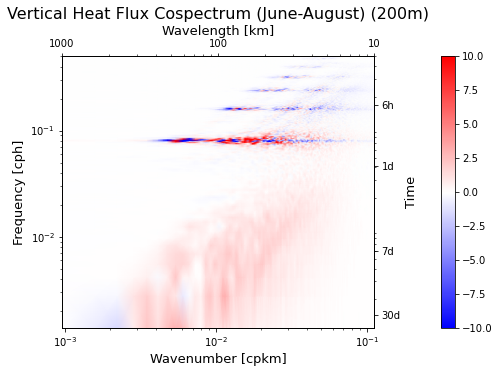

In [84]:
#====================================================
#===================================================
kk = kiso[1:]
omm = om[1:]
#ff = coriolis(38)
#f0 =  0.89e-4
#print(f0)
#kiso = np.logspace(-3,0.,100)

#################
fig = plt.figure(figsize=(8,5))

#fig = plt.figure(figsize=(10,6))
#ax1 = plt.subplot2grid((3,6),(0,1),colspan=2)
#ax2 = plt.subplot2grid((3,6),(1,0),rowspan=2)
#ax3 = plt.subplot2grid((3,6),(1,1),rowspan=2, colspan=2)
ax1 = fig.add_subplot(111)
cs=plt.pcolormesh(kk,omm,60*1*Eiso_units.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='bwr' )
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title('Vertical Heat Flux Cospectrum (June-August) (200m)', size=16)
plt.xlabel(r'Wavenumber [cpkm]',size=13)
plt.ylabel(r'Frequency [cph]',size=13)
plt.clim([-10,10])
plt.colorbar(pad=0.15)
#ax1.set_ylim([omm[1], omm[-1]])
#ax1.set_xlim([kk[1],1e-1])
#ax3.set_yticks([])
#plt.title('Mode-1',fontweight='bold',size=20)
#

#plt.savefig(PrntOut+figurename+output_format,format='png',
#            dpi=500,bbox_inches='tight')
ax1a = ax1.twiny()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_xlim(1./1000.,1/10.)
ax1a.set_xticks([1/1000.,1/100.,1/10.])
ax1a.set_xticklabels(['1000','100','10'])
ax1a.set_xlabel('Wavelength [km]',size=13)
ax1a = ax1.twinx()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_ylim(1/(24.*40.),1/2.)
ax1a.set_yticks([1/6, 1/24.,1/(24.*7.),1/(24*30.)])
ax1a.set_yticklabels(['6h','1d','7d','30d'])
ax1a.set_ylabel('Time', size=13)
plt.show()


In [85]:
W15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'W', 32,32)
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'Theta', 32, 32)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [86]:
W15c = W15.W.compute()[int(W15.W.time.size / 2):]
T15c = T15.Theta.compute()[int(T15.Theta.time.size / 2):]

In [87]:
W15_reg = regularizeCoordinates(W15c,'linear',timeunits = 'hours')
T15_reg = regularizeCoordinates(T15c,'linear',timeunits = 'hours')

In [88]:
T15_reg.time.size

2208

In [89]:
W15_t = xrft.detrend(W15_reg, dim = 'time', detrend_type = 'linear')
W15_txy = xrft.detrend(W15_t, dim = ['xdim','ydim'], detrend_type = 'linear')
T15_t = xrft.detrend(T15_reg, dim = 'time', detrend_type = 'linear')
T15_txy = xrft.detrend(T15_t, dim = ['xdim','ydim'], detrend_type = 'linear')

In [90]:
W15_np = W15_txy.values
W15_np_swap = np.swapaxes(np.swapaxes(W15_np, 0, 1), 1,2)
T15_np = T15_txy.values
T15_np_swap = np.swapaxes(np.swapaxes(T15_np, 0, 1), 1, 2)

In [91]:
dx = W15_txy.xdim.diff('xdim').mean().values
dy = W15_txy.ydim.diff('ydim').mean().values
dt = W15_txy.time.diff('time').mean().values

In [92]:
dt

array(1.)

In [93]:
u = W15_np_swap
v = T15_np_swap

In [94]:
import co_spec

In [95]:
# Preambule
iy,ix,it = u.shape
#print(it,iy,ix)
iaux = (30*24)#(60*24*7)/10 #(7*24)
nt = np.around(it/(iaux),decimals=1)
print(nt)

# Calclate the 3D spectrum
for i in range(int(nt)):
      uaux = u[:,:,i*iaux:i*iaux+iaux]
      vaux = v[:,:,i*iaux:i*iaux+iaux]
      if i == 0:
         Eu,k,l,om, df1, df2, df3 = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
      else:
         Eua,_,_,_,_,_,_ = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
         Eu = Eu + Eua
Eu = Eu/nt
#USE SAME RESOLUTION IN THE DX AND DY!!!

3.1
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993


In [96]:
def calc_ispec(k,l,E):
    """ calculates isotropic spectrum from 2D spectrum """

    dk,dl = k[1,]-k[0],l[1]-l[0]
    l,k = np.meshgrid(l,k)
    wv = np.sqrt(k**2 + l**2)

    if k.max()>l.max():
        kmax = l.max()
    else:
        kmax = k.max()

    # create radial wavenumber
    dkr = np.sqrt(dk**2 + dl**2)
    kr =  np.arange(dkr/2.,kmax+dkr,dkr)
    ispec = np.zeros(kr.size)
    #print(ispec.shape)
    #print(kr.shape)
    for i in range(kr.size):
        fkr =  (wv>=kr[i]-dkr/2) & (wv<=kr[i]+dkr/2)
    #    print(fkr.shape)
        dth = np.pi / (fkr.sum()-1)
        ispec[i] = E[fkr].sum() * kr[i] * dth

    return kr, ispec

In [97]:
I = 0
for i in range(om.size-1):
    kiso,Ei = calc_ispec(k,l,Eu[:,:,i])
    if I == 0:
        Eiso = np.empty((len(Ei),om.size))
    Eiso[:,i] = Ei
    I = I + 1

In [98]:
Eiso_units = Eiso*4.2e6# rho Cp

<ipython-input-98-2561f5a81033>:1: RuntimeWarning: overflow encountered in multiply
  Eiso_units = Eiso*4.2e6# rho Cp


In [99]:
np.isnan(Eiso).sum()

1

In [100]:
#Eiso_units= Eiso#*4.2e6
#Eiso_units.shape

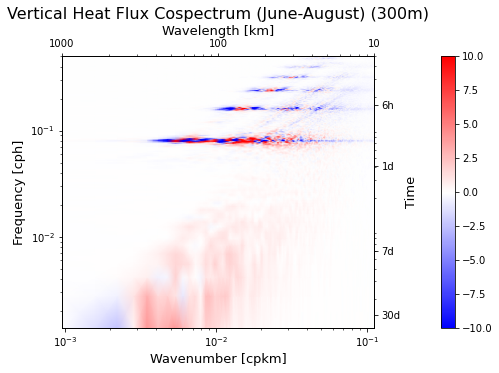

In [101]:
#====================================================
#===================================================
kk = kiso[1:]
omm = om[1:]
#ff = coriolis(38)
#f0 =  0.89e-4
#print(f0)
#kiso = np.logspace(-3,0.,100)

#################
fig = plt.figure(figsize=(8,5))

#fig = plt.figure(figsize=(10,6))
#ax1 = plt.subplot2grid((3,6),(0,1),colspan=2)
#ax2 = plt.subplot2grid((3,6),(1,0),rowspan=2)
#ax3 = plt.subplot2grid((3,6),(1,1),rowspan=2, colspan=2)
ax1 = fig.add_subplot(111)
cs=plt.pcolormesh(kk,omm,60*1*Eiso_units.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='bwr' )
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title('Vertical Heat Flux Cospectrum (June-August) (300m)', size=16)
plt.xlabel(r'Wavenumber [cpkm]',size=13)
plt.ylabel(r'Frequency [cph]',size=13)
plt.clim([-10,10])
plt.colorbar(pad=0.15)
#ax1.set_ylim([omm[1], omm[-1]])
#ax1.set_xlim([kk[1],1e-1])
#ax3.set_yticks([])
#plt.title('Mode-1',fontweight='bold',size=20)
#

#plt.savefig(PrntOut+figurename+output_format,format='png',
#            dpi=500,bbox_inches='tight')
ax1a = ax1.twiny()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_xlim(1./1000.,1/10.)
ax1a.set_xticks([1/1000.,1/100.,1/10.])
ax1a.set_xticklabels(['1000','100','10'])
ax1a.set_xlabel('Wavelength [km]',size=13)
ax1a = ax1.twinx()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_ylim(1/(24.*40.),1/2.)
ax1a.set_yticks([1/6, 1/24.,1/(24.*7.),1/(24*30.)])
ax1a.set_yticklabels(['6h','1d','7d','30d'])
ax1a.set_ylabel('Time', size=13)
plt.show()


In [102]:
W15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'W', 36,36)
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region/', 'Theta', 36, 36)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [103]:
W15c = W15.W.compute()[int(W15.W.time.size / 2):]
T15c = T15.Theta.compute()[int(T15.Theta.time.size / 2):]

In [104]:
W15_reg = regularizeCoordinates(W15c,'linear',timeunits = 'hours')
T15_reg = regularizeCoordinates(T15c,'linear',timeunits = 'hours')

In [105]:
T15_reg.time.size

2208

In [106]:
W15_t = xrft.detrend(W15_reg, dim = 'time', detrend_type = 'linear')
W15_txy = xrft.detrend(W15_t, dim = ['xdim','ydim'], detrend_type = 'linear')
T15_t = xrft.detrend(T15_reg, dim = 'time', detrend_type = 'linear')
T15_txy = xrft.detrend(T15_t, dim = ['xdim','ydim'], detrend_type = 'linear')

In [107]:
W15_np = W15_txy.values
W15_np_swap = np.swapaxes(np.swapaxes(W15_np, 0, 1), 1,2)
T15_np = T15_txy.values
T15_np_swap = np.swapaxes(np.swapaxes(T15_np, 0, 1), 1, 2)

In [108]:
dx = W15_txy.xdim.diff('xdim').mean().values
dy = W15_txy.ydim.diff('ydim').mean().values
dt = W15_txy.time.diff('time').mean().values

In [109]:
dt

array(1.)

In [110]:
u = W15_np_swap
v = T15_np_swap

In [111]:
import co_spec

In [112]:
# Preambule
iy,ix,it = u.shape
#print(it,iy,ix)
iaux = (30*24)#(60*24*7)/10 #(7*24)
nt = np.around(it/(iaux),decimals=1)
print(nt)

# Calclate the 3D spectrum
for i in range(int(nt)):
      uaux = u[:,:,i*iaux:i*iaux+iaux]
      vaux = v[:,:,i*iaux:i*iaux+iaux]
      if i == 0:
         Eu,k,l,om, df1, df2, df3 = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
      else:
         Eua,_,_,_,_,_,_ = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
         Eu = Eu + Eua
Eu = Eu/nt
#USE SAME RESOLUTION IN THE DX AND DY!!!

3.1
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993


In [113]:
def calc_ispec(k,l,E):
    """ calculates isotropic spectrum from 2D spectrum """

    dk,dl = k[1,]-k[0],l[1]-l[0]
    l,k = np.meshgrid(l,k)
    wv = np.sqrt(k**2 + l**2)

    if k.max()>l.max():
        kmax = l.max()
    else:
        kmax = k.max()

    # create radial wavenumber
    dkr = np.sqrt(dk**2 + dl**2)
    kr =  np.arange(dkr/2.,kmax+dkr,dkr)
    ispec = np.zeros(kr.size)
    #print(ispec.shape)
    #print(kr.shape)
    for i in range(kr.size):
        fkr =  (wv>=kr[i]-dkr/2) & (wv<=kr[i]+dkr/2)
    #    print(fkr.shape)
        dth = np.pi / (fkr.sum()-1)
        ispec[i] = E[fkr].sum() * kr[i] * dth

    return kr, ispec

In [114]:
I = 0
for i in range(om.size-1):
    kiso,Ei = calc_ispec(k,l,Eu[:,:,i])
    if I == 0:
        Eiso = np.empty((len(Ei),om.size))
    Eiso[:,i] = Ei
    I = I + 1

In [115]:
Eiso_units = Eiso*4.2e6# rho Cp

In [116]:
np.isnan(Eiso).sum()

0

In [117]:
#Eiso_units= Eiso#*4.2e6
#Eiso_units.shape

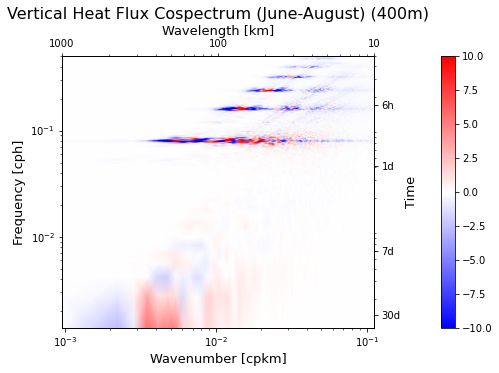

In [118]:
#====================================================
#===================================================
kk = kiso[1:]
omm = om[1:]
#ff = coriolis(38)
#f0 =  0.89e-4
#print(f0)
#kiso = np.logspace(-3,0.,100)

#################
fig = plt.figure(figsize=(8,5))

#fig = plt.figure(figsize=(10,6))
#ax1 = plt.subplot2grid((3,6),(0,1),colspan=2)
#ax2 = plt.subplot2grid((3,6),(1,0),rowspan=2)
#ax3 = plt.subplot2grid((3,6),(1,1),rowspan=2, colspan=2)
ax1 = fig.add_subplot(111)
cs=plt.pcolormesh(kk,omm,60*1*Eiso_units.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='bwr' )
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title('Vertical Heat Flux Cospectrum (June-August) (400m)', size=16)
plt.xlabel(r'Wavenumber [cpkm]',size=13)
plt.ylabel(r'Frequency [cph]',size=13)
plt.clim([-10,10])
plt.colorbar(pad=0.15)
#ax1.set_ylim([omm[1], omm[-1]])
#ax1.set_xlim([kk[1],1e-1])
#ax3.set_yticks([])
#plt.title('Mode-1',fontweight='bold',size=20)
#

#plt.savefig(PrntOut+figurename+output_format,format='png',
#            dpi=500,bbox_inches='tight')
ax1a = ax1.twiny()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_xlim(1./1000.,1/10.)
ax1a.set_xticks([1/1000.,1/100.,1/10.])
ax1a.set_xticklabels(['1000','100','10'])
ax1a.set_xlabel('Wavelength [km]',size=13)
ax1a = ax1.twinx()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_ylim(1/(24.*40.),1/2.)
ax1a.set_yticks([1/6, 1/24.,1/(24.*7.),1/(24*30.)])
ax1a.set_yticklabels(['6h','1d','7d','30d'])
ax1a.set_ylabel('Time', size=13)
plt.show()


Now, it would be very interesting to look North and South of the gulf stream. How to do that ? . . . 

I'm going to look at kinetic energy movies and see if I can pick out north and south of the gulf stream.

Below here is the fall sections!

---------------------------------------------------------------------------------------------------------------------------------------------
Rerun this code once the sections are corrected

In [3]:
W15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region_fall_winter//', 'W', 15,15)
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region_fall_winter//', 'Theta', 15,15)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [16]:
W15c = W15.W.compute()[0:int(24*30*3)]
T15c = T15.Theta.compute()[0:int(24*30*3)]

In [17]:
W15_reg = regularizeCoordinates(W15c,'linear',timeunits = 'hours')
T15_reg = regularizeCoordinates(T15c,'linear',timeunits = 'hours')

In [6]:
T15_reg.time.size

3389

In [18]:
W15_t = xrft.detrend(W15_reg, dim = 'time', detrend_type = 'linear')
W15_txy = xrft.detrend(W15_t, dim = ['xdim','ydim'], detrend_type = 'linear')
T15_t = xrft.detrend(T15_reg, dim = 'time', detrend_type = 'linear')
T15_txy = xrft.detrend(T15_t, dim = ['xdim','ydim'], detrend_type = 'linear')

In [19]:
W15_np = W15_txy.values
W15_np_swap = np.swapaxes(np.swapaxes(W15_np, 0, 1), 1,2)
T15_np = T15_txy.values
T15_np_swap = np.swapaxes(np.swapaxes(T15_np, 0, 1), 1, 2)

In [21]:
dx = W15_txy.xdim.diff('xdim').mean().values
dy = W15_txy.ydim.diff('ydim').mean().values
dt = W15_txy.time.diff('time').mean().values

In [10]:
dt

array(1.)

In [20]:
u = W15_np_swap
v = T15_np_swap

In [12]:
u.shape

(500, 500, 2172)

In [13]:
v.shape

(500, 500, 1181)

In [22]:
import co_spec

In [23]:
# Preambule
iy,ix,it = u.shape
#print(it,iy,ix)
iaux = (30*24)#(60*24*7)/10 #(7*24)
nt = np.around(it/(iaux),decimals=1)
print(nt)

# Calclate the 3D spectrum
for i in range(int(nt)):
      uaux = u[:,:,i*iaux:i*iaux+iaux]
      vaux = v[:,:,i*iaux:i*iaux+iaux]
      if i == 0:
         Eu,k,l,om, df1, df2, df3 = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
      else:
         Eua,_,_,_,_,_,_ = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
         Eu = Eu + Eua
Eu = Eu/nt
#USE SAME RESOLUTION IN THE DX AND DY!!!

3.0
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993


In [24]:
def calc_ispec(k,l,E):
    """ calculates isotropic spectrum from 2D spectrum """

    dk,dl = k[1,]-k[0],l[1]-l[0]
    l,k = np.meshgrid(l,k)
    wv = np.sqrt(k**2 + l**2)

    if k.max()>l.max():
        kmax = l.max()
    else:
        kmax = k.max()

    # create radial wavenumber
    dkr = np.sqrt(dk**2 + dl**2)
    kr =  np.arange(dkr/2.,kmax+dkr,dkr)
    ispec = np.zeros(kr.size)
    #print(ispec.shape)
    #print(kr.shape)
    for i in range(kr.size):
        fkr =  (wv>=kr[i]-dkr/2) & (wv<=kr[i]+dkr/2)
    #    print(fkr.shape)
        dth = np.pi / (fkr.sum()-1)
        ispec[i] = E[fkr].sum() * kr[i] * dth

    return kr, ispec

In [25]:
I = 0
for i in range(om.size-1):
    kiso,Ei = calc_ispec(k,l,Eu[:,:,i])
    if I == 0:
        Eiso = np.empty((len(Ei),om.size))
    Eiso[:,i] = Ei
    I = I + 1

In [26]:
Eiso_units = Eiso*4.2e6# rho Cp

In [17]:
np.isnan(Eiso).sum()

0

In [18]:
#Eiso_units= Eiso#*4.2e6
#Eiso_units.shape

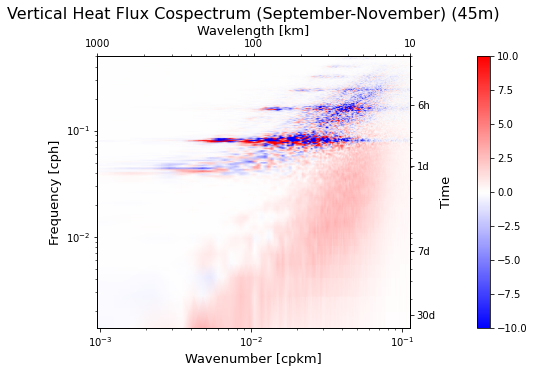

In [28]:
#====================================================
#===================================================
kk = kiso[1:]
omm = om[1:]
#ff = coriolis(38)
#f0 =  0.89e-4
#print(f0)
#kiso = np.logspace(-3,0.,100)

#################
fig = plt.figure(figsize=(8,5))

#fig = plt.figure(figsize=(10,6))
#ax1 = plt.subplot2grid((3,6),(0,1),colspan=2)
#ax2 = plt.subplot2grid((3,6),(1,0),rowspan=2)
#ax3 = plt.subplot2grid((3,6),(1,1),rowspan=2, colspan=2)
ax1 = fig.add_subplot(111)
cs=plt.pcolormesh(kk,omm,60*1*Eiso_units.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='bwr' )
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title('Vertical Heat Flux Cospectrum (September-November) (45m)', size=16)
plt.xlabel(r'Wavenumber [cpkm]',size=13)
plt.ylabel(r'Frequency [cph]',size=13)
plt.clim([-10,10])
plt.colorbar(pad=0.15)
#ax1.set_ylim([omm[1], omm[-1]])
#ax1.set_xlim([kk[1],1e-1])
#ax3.set_yticks([])
#plt.title('Mode-1',fontweight='bold',size=20)
#

#plt.savefig(PrntOut+figurename+output_format,format='png',
#            dpi=500,bbox_inches='tight')
ax1a = ax1.twiny()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_xlim(1./1000.,1/10.)
ax1a.set_xticks([1/1000.,1/100.,1/10.])
ax1a.set_xticklabels(['1000','100','10'])
ax1a.set_xlabel('Wavelength [km]',size=13)
ax1a = ax1.twinx()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_ylim(1/(24.*40.),1/2.)
ax1a.set_yticks([1/6, 1/24.,1/(24.*7.),1/(24*30.)])
ax1a.set_yticklabels(['6h','1d','7d','30d'])
ax1a.set_ylabel('Time', size=13)
plt.show()


In [20]:
W15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region_fall_winter//', 'W', 28,28)
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region_fall_winter//', 'Theta', 28,28)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [21]:
W15c = W15.W.compute()[int(W15.W.time.size / 2):]
T15c = T15.Theta.compute()[int(T15.Theta.time.size / 2):]

In [22]:
W15_reg = regularizeCoordinates(W15c,'linear',timeunits = 'hours')
T15_reg = regularizeCoordinates(T15c,'linear',timeunits = 'hours')

In [23]:
T15_reg.time.size

2208

In [24]:
W15_t = xrft.detrend(W15_reg, dim = 'time', detrend_type = 'linear')
W15_txy = xrft.detrend(W15_t, dim = ['xdim','ydim'], detrend_type = 'linear')
T15_t = xrft.detrend(T15_reg, dim = 'time', detrend_type = 'linear')
T15_txy = xrft.detrend(T15_t, dim = ['xdim','ydim'], detrend_type = 'linear')

In [25]:
W15_np = W15_txy.values
W15_np_swap = np.swapaxes(np.swapaxes(W15_np, 0, 1), 1,2)
T15_np = T15_txy.values
T15_np_swap = np.swapaxes(np.swapaxes(T15_np, 0, 1), 1, 2)

In [26]:
dx = W15_txy.xdim.diff('xdim').mean().values
dy = W15_txy.ydim.diff('ydim').mean().values
dt = W15_txy.time.diff('time').mean().values

In [27]:
dt

array(1.)

In [28]:
u = W15_np_swap
v = T15_np_swap

In [29]:
import co_spec

In [30]:
# Preambule
iy,ix,it = u.shape
#print(it,iy,ix)
iaux = (30*24)#(60*24*7)/10 #(7*24)
nt = np.around(it/(iaux),decimals=1)
print(nt)

# Calclate the 3D spectrum
for i in range(int(nt)):
      uaux = u[:,:,i*iaux:i*iaux+iaux]
      vaux = v[:,:,i*iaux:i*iaux+iaux]
      if i == 0:
         Eu,k,l,om, df1, df2, df3 = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
      else:
         Eua,_,_,_,_,_,_ = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
         Eu = Eu + Eua
Eu = Eu/nt
#USE SAME RESOLUTION IN THE DX AND DY!!!

3.1
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993


In [31]:
def calc_ispec(k,l,E):
    """ calculates isotropic spectrum from 2D spectrum """

    dk,dl = k[1,]-k[0],l[1]-l[0]
    l,k = np.meshgrid(l,k)
    wv = np.sqrt(k**2 + l**2)

    if k.max()>l.max():
        kmax = l.max()
    else:
        kmax = k.max()

    # create radial wavenumber
    dkr = np.sqrt(dk**2 + dl**2)
    kr =  np.arange(dkr/2.,kmax+dkr,dkr)
    ispec = np.zeros(kr.size)
    #print(ispec.shape)
    #print(kr.shape)
    for i in range(kr.size):
        fkr =  (wv>=kr[i]-dkr/2) & (wv<=kr[i]+dkr/2)
    #    print(fkr.shape)
        dth = np.pi / (fkr.sum()-1)
        ispec[i] = E[fkr].sum() * kr[i] * dth

    return kr, ispec

In [32]:
I = 0
for i in range(om.size-1):
    kiso,Ei = calc_ispec(k,l,Eu[:,:,i])
    if I == 0:
        Eiso = np.empty((len(Ei),om.size))
    Eiso[:,i] = Ei
    I = I + 1

In [33]:
Eiso_units = Eiso*4.2e6# rho Cp

In [34]:
np.isnan(Eiso).sum()

0

In [35]:
#Eiso_units= Eiso#*4.2e6
#Eiso_units.shape

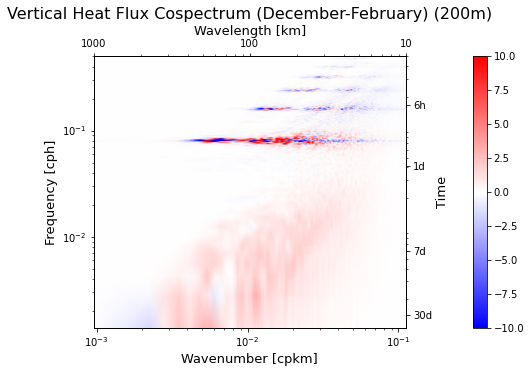

In [36]:
#====================================================
#===================================================
kk = kiso[1:]
omm = om[1:]
#ff = coriolis(38)
#f0 =  0.89e-4
#print(f0)
#kiso = np.logspace(-3,0.,100)

#################
fig = plt.figure(figsize=(8,5))

#fig = plt.figure(figsize=(10,6))
#ax1 = plt.subplot2grid((3,6),(0,1),colspan=2)
#ax2 = plt.subplot2grid((3,6),(1,0),rowspan=2)
#ax3 = plt.subplot2grid((3,6),(1,1),rowspan=2, colspan=2)
ax1 = fig.add_subplot(111)
cs=plt.pcolormesh(kk,omm,60*1*Eiso_units.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='bwr' )
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title('Vertical Heat Flux Cospectrum (December-February) (200m)', size=16)
plt.xlabel(r'Wavenumber [cpkm]',size=13)
plt.ylabel(r'Frequency [cph]',size=13)
plt.clim([-10,10])
plt.colorbar(pad=0.15)
#ax1.set_ylim([omm[1], omm[-1]])
#ax1.set_xlim([kk[1],1e-1])
#ax3.set_yticks([])
#plt.title('Mode-1',fontweight='bold',size=20)
#

#plt.savefig(PrntOut+figurename+output_format,format='png',
#            dpi=500,bbox_inches='tight')
ax1a = ax1.twiny()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_xlim(1./1000.,1/10.)
ax1a.set_xticks([1/1000.,1/100.,1/10.])
ax1a.set_xticklabels(['1000','100','10'])
ax1a.set_xlabel('Wavelength [km]',size=13)
ax1a = ax1.twinx()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_ylim(1/(24.*40.),1/2.)
ax1a.set_yticks([1/6, 1/24.,1/(24.*7.),1/(24*30.)])
ax1a.set_yticklabels(['6h','1d','7d','30d'])
ax1a.set_ylabel('Time', size=13)
plt.show()


In [54]:
W15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region_fall_winter//', 'W', 32,32)
T15 = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month_bigger_region_fall_winter//', 'Theta', 32,32)

Time combined dataset has been opened.
I concatenated the first Z-layer
Time combined dataset has been opened.
I concatenated the first Z-layer


In [55]:
W15c = W15.W.compute()[int(W15.W.time.size / 2):]
T15c = T15.Theta.compute()[int(T15.Theta.time.size / 2):]

In [56]:
W15_reg = regularizeCoordinates(W15c,'linear',timeunits = 'hours')
T15_reg = regularizeCoordinates(T15c,'linear',timeunits = 'hours')

In [57]:
T15_reg.time.size

2208

In [58]:
W15_t = xrft.detrend(W15_reg, dim = 'time', detrend_type = 'linear')
W15_txy = xrft.detrend(W15_t, dim = ['xdim','ydim'], detrend_type = 'linear')
T15_t = xrft.detrend(T15_reg, dim = 'time', detrend_type = 'linear')
T15_txy = xrft.detrend(T15_t, dim = ['xdim','ydim'], detrend_type = 'linear')

In [59]:
W15_np = W15_txy.values
W15_np_swap = np.swapaxes(np.swapaxes(W15_np, 0, 1), 1,2)
T15_np = T15_txy.values
T15_np_swap = np.swapaxes(np.swapaxes(T15_np, 0, 1), 1, 2)

In [60]:
dx = W15_txy.xdim.diff('xdim').mean().values
dy = W15_txy.ydim.diff('ydim').mean().values
dt = W15_txy.time.diff('time').mean().values

In [61]:
dt

array(1.)

In [62]:
u = W15_np_swap
v = T15_np_swap

In [63]:
import co_spec

In [64]:
# Preambule
iy,ix,it = u.shape
#print(it,iy,ix)
iaux = (30*24)#(60*24*7)/10 #(7*24)
nt = np.around(it/(iaux),decimals=1)
print(nt)

# Calclate the 3D spectrum
for i in range(int(nt)):
      uaux = u[:,:,i*iaux:i*iaux+iaux]
      vaux = v[:,:,i*iaux:i*iaux+iaux]
      if i == 0:
         Eu,k,l,om, df1, df2, df3 = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
      else:
         Eua,_,_,_,_,_,_ = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
         Eu = Eu + Eua
Eu = Eu/nt
#USE SAME RESOLUTION IN THE DX AND DY!!!

3.1
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993
before fftn
500 500 720
0.11241116021938993
0.11241116021938993


In [65]:
def calc_ispec(k,l,E):
    """ calculates isotropic spectrum from 2D spectrum """

    dk,dl = k[1,]-k[0],l[1]-l[0]
    l,k = np.meshgrid(l,k)
    wv = np.sqrt(k**2 + l**2)

    if k.max()>l.max():
        kmax = l.max()
    else:
        kmax = k.max()

    # create radial wavenumber
    dkr = np.sqrt(dk**2 + dl**2)
    kr =  np.arange(dkr/2.,kmax+dkr,dkr)
    ispec = np.zeros(kr.size)
    #print(ispec.shape)
    #print(kr.shape)
    for i in range(kr.size):
        fkr =  (wv>=kr[i]-dkr/2) & (wv<=kr[i]+dkr/2)
    #    print(fkr.shape)
        dth = np.pi / (fkr.sum()-1)
        ispec[i] = E[fkr].sum() * kr[i] * dth

    return kr, ispec

In [66]:
I = 0
for i in range(om.size-1):
    kiso,Ei = calc_ispec(k,l,Eu[:,:,i])
    if I == 0:
        Eiso = np.empty((len(Ei),om.size))
    Eiso[:,i] = Ei
    I = I + 1

In [67]:
Eiso_units = Eiso*4.2e6# rho Cp

In [68]:
np.isnan(Eiso).sum()

16

In [69]:
#Eiso_units= Eiso#*4.2e6
#Eiso_units.shape

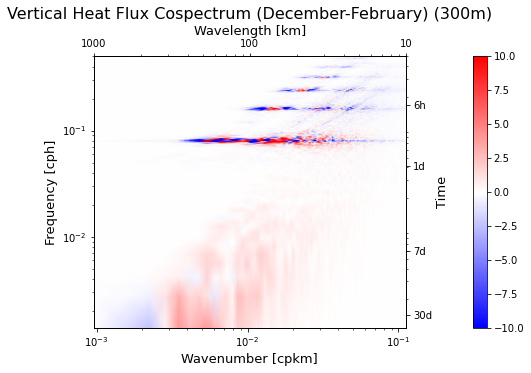

In [70]:
#====================================================
#===================================================
kk = kiso[1:]
omm = om[1:]
#ff = coriolis(38)
#f0 =  0.89e-4
#print(f0)
#kiso = np.logspace(-3,0.,100)

#################
fig = plt.figure(figsize=(8,5))

#fig = plt.figure(figsize=(10,6))
#ax1 = plt.subplot2grid((3,6),(0,1),colspan=2)
#ax2 = plt.subplot2grid((3,6),(1,0),rowspan=2)
#ax3 = plt.subplot2grid((3,6),(1,1),rowspan=2, colspan=2)
ax1 = fig.add_subplot(111)
cs=plt.pcolormesh(kk,omm,60*1*Eiso_units.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='bwr' )
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title('Vertical Heat Flux Cospectrum (December-February) (300m)', size=16)
plt.xlabel(r'Wavenumber [cpkm]',size=13)
plt.ylabel(r'Frequency [cph]',size=13)
plt.clim([-10,10])
plt.colorbar(pad=0.15)
#ax1.set_ylim([omm[1], omm[-1]])
#ax1.set_xlim([kk[1],1e-1])
#ax3.set_yticks([])
#plt.title('Mode-1',fontweight='bold',size=20)
#

#plt.savefig(PrntOut+figurename+output_format,format='png',
#            dpi=500,bbox_inches='tight')
ax1a = ax1.twiny()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_xlim(1./1000.,1/10.)
ax1a.set_xticks([1/1000.,1/100.,1/10.])
ax1a.set_xticklabels(['1000','100','10'])
ax1a.set_xlabel('Wavelength [km]',size=13)
ax1a = ax1.twinx()
ax1a.set_yscale('log')
ax1a.set_xscale('log')
ax1a.set_ylim(1/(24.*40.),1/2.)
ax1a.set_yticks([1/6, 1/24.,1/(24.*7.),1/(24*30.)])
ax1a.set_yticklabels(['6h','1d','7d','30d'])
ax1a.set_ylabel('Time', size=13)
plt.show()
